# Description

This notebooks performs QA checks for Crypto Chassis `coinbase`:
   - Number of NaN data points as % of total
   - Number of data points where `volume=0` as % of total

# Imports

In [1]:
import logging
import os

import pandas as pd

import core.config.config_ as cconconf
import core.config.config_utils as ccocouti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.crypto_chassis.data.client as imvccdc
import research_amp.cc.qa as ramccqa

/app/helpers/hparquet.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-810011f9-785b-4cea-83e6-8884458b1e4c.json'
INFO  # Git
    branch_name='CMTask2051_Run_QA_for_coinbase'
    hash='762540791'
    # Last commits:
      * 762540791 Nina Lee Cm task1999 update compare data calls in the notebooks (#2040)    (22 minutes ago) Wed Jun 1 15:10:50 2022  (HEAD -> CMTask2051_Run_QA_for_coinbase, origin/master, origin/HEAD, master)
      * d4aab52c5 cryptomtc AmpTask1786_Integrate_20220531 (#2045)                            (65 minutes ago) Wed Jun 1 14:27:35 2022           
      * bf8761a75 Daniil Tikhomirov CMTask2043: Update parquet files merging (#2049)                  (   2 hours ago) Wed Jun 1 13:48:36 2022           
# Machine info
    system=Linux
    node name=338f016b0bee
    release=5.13.0-1022-aws
    version=#24~20.04.1-Ubuntu SMP Thu Apr 7 22:10:15 UTC 2022
    machine=x86_64
    processor=x86_64
    cpu count=8
    cpu freq=scpufreq(c

# Configs

In [3]:
def get_cmtask2051_config_crypto_chassis() -> cconconf.Config:
    """
    Get task2051-specific config.
    """
    config = cconconf.Config()
    param_dict = {
        "vendor": "crypto_chassis",
        "data": {
            # Parameters for client initialization.
            "im_client": {
                "universe_version": "v2",
                "resample_1min": False,
                "root_dir": os.path.join(
                    hs3.get_s3_bucket_path("ck"), "reorg", "historical.manual.pq"
                ),
                "partition_mode": "by_year_month",
                "data_snapshot": "20220530",
                "aws_profile": "ck",
            },
            # Parameters for data query.
            "read_data": {
                "start_ts": None,
                "end_ts": None,
                "columns": ["full_symbol", "close", "volume"],
                "filter_data_mode": "assert",
            },
        },
        "column_names": {
            "full_symbol": "full_symbol",
            "close_price": "close",
        },
        "stats": {
            "threshold": 30,
        },
    }
    config = cconfig.Config.from_dict(param_dict)
    return config

In [4]:
config = get_cmtask2051_config_crypto_chassis()
print(config)

data:
  im_client:
    universe_version: v2
    resample_1min: False
    root_dir: s3://cryptokaizen-data/reorg/historical.manual.pq
    partition_mode: by_year_month
    data_snapshot: 20220530
    aws_profile: ck
  read_data:
    start_ts: None
    end_ts: None
    columns: ['full_symbol', 'close', 'volume']
    filter_data_mode: assert
column_names:
  full_symbol: full_symbol
  close_price: close
stats:
  threshold: 30


# Functions

In [5]:
# TODO(Dan): Add filtering by dates.
def _plot_bad_data_by_year_month_stats(
    config: cconconf.Config, bad_data_stats: pd.DataFrame
) -> None:
    """
    Plot bad data stats by year and month per unique full symbol in data.

    Bad data is the sum of NaNs and "volume=0" stats.
    """
    full_symbols = bad_data_stats.index.get_level_values(0).unique()
    for full_symbol in full_symbols:
        bad_data_col_name = "bad data [%]"
        ax = bad_data_stats.loc[full_symbol].plot.bar(
            y=bad_data_col_name, rot=0, title=full_symbol
        )
        #
        ax.hlines(
            y=config["stats"]["threshold"],
            xmin=0,
            xmax=len(bad_data_stats),
            color="r",
        )
        # TODO(Dan): Make ticklabels more readable.
        # Get ticks and labels for x-axis.
        ticks = ax.xaxis.get_ticklocs()
        ticklabels = [
            l.get_text().strip("()").split(", ")
            for l in ax.xaxis.get_ticklabels()
        ]
        ticklabels = [".".join([l[0], l[1]]) for l in ticklabels]
        # Adjust x-axis labels so they do not overlap on plot by
        # picking ticks and labels by specified stride that limits
        # the number of final ticks to 10.
        stride = len(ticks) // 10 + 1
        ax.xaxis.set_ticks(ticks[::stride])
        ax.xaxis.set_ticklabels(ticklabels[::stride])
        ax.figure.show()

# QA checks

Major metric for a QA check is `"bad data [%]"` which is the sum of `"volume=0 [%]"` and `"NaNs [%]"`.

In [6]:
client = imvccdc.crypto_chassis_clients.CryptoChassisHistoricalPqByTileClient(
    **config["data"]["im_client"]
)

In [7]:
universe = client.get_universe()
universe

['binance::ADA_USDT',
 'binance::BNB_USDT',
 'binance::BTC_USDT',
 'binance::DOGE_USDT',
 'binance::EOS_USDT',
 'binance::ETH_USDT',
 'binance::SOL_USDT',
 'coinbase::BTC_USDT',
 'coinbase::DOGE_USDT',
 'coinbase::ETH_USDT',
 'coinbase::SOL_USDT',
 'ftx::BNB_USDT',
 'ftx::BTC_USDT',
 'ftx::DOGE_USDT',
 'ftx::ETH_USDT',
 'ftx::SOL_USDT',
 'ftx::XRP_USDT',
 'gateio::ADA_USDT',
 'gateio::BNB_USDT',
 'gateio::BTC_USDT',
 'gateio::DOGE_USDT',
 'gateio::EOS_USDT',
 'gateio::ETH_USDT',
 'gateio::SOL_USDT',
 'gateio::XRP_USDT',
 'kucoin::ADA_USDT',
 'kucoin::BNB_USDT',
 'kucoin::BTC_USDT',
 'kucoin::DOGE_USDT',
 'kucoin::EOS_USDT',
 'kucoin::ETH_USDT',
 'kucoin::SOL_USDT',
 'kucoin::XRP_USDT']

## Coinbase

In [8]:
coinbase_universe = [
    full_symbol for full_symbol in universe if full_symbol.startswith("coinbase")
]
coinbase_universe

['coinbase::BTC_USDT',
 'coinbase::DOGE_USDT',
 'coinbase::ETH_USDT',
 'coinbase::SOL_USDT']

In [9]:
coinbase_data = client.read_data(coinbase_universe, **config["data"]["read_data"])
coinbase_data.head(3)

,full_symbol,close,volume
timestamp,,,
2021-10-12 04:07:00+00:00,coinbase::BTC_USDT,56799.5100,0.184718
2021-10-12 04:07:00+00:00,coinbase::DOGE_USDT,0.2239,620.000000
2021-10-12 04:07:00+00:00,coinbase::ETH_USDT,3486.3600,1.375485


In [10]:
vendor_name = config["vendor"]
coinbase_timestamp_stats = ramccqa.get_timestamp_stats(coinbase_data, vendor_name)
coinbase_timestamp_stats

,min_timestamp,max_timestamp,days_available
coinbase::BTC_USDT,2021-10-12 04:07:00+00:00,2022-05-30 23:59:00+00:00,230
coinbase::DOGE_USDT,2021-10-12 04:07:00+00:00,2022-05-30 23:59:00+00:00,230
coinbase::ETH_USDT,2021-10-12 04:07:00+00:00,2022-05-30 23:59:00+00:00,230
coinbase::SOL_USDT,2021-10-13 17:48:00+00:00,2022-05-30 23:59:00+00:00,229


In [11]:
agg_level_full_symbol = ["full_symbol"]
coinbase_bad_data_stats = ramccqa.get_bad_data_stats(
    coinbase_data, agg_level_full_symbol, vendor_name
)
coinbase_bad_data_stats

,bad data [%],missing bars [%],volume=0 [%],NaNs [%]
coinbase::BTC_USDT,9.087737,9.087737,0.0,0.0
coinbase::DOGE_USDT,47.797336,47.797336,0.0,0.0
coinbase::ETH_USDT,11.452708,11.452708,0.0,0.0
coinbase::SOL_USDT,13.213502,13.213502,0.0,0.0


In [12]:
agg_level_full_symbol_year_month = ["full_symbol", "year", "month"]
coinbase_bad_data_stats_by_year_month = ramccqa.get_bad_data_stats(
    coinbase_data, agg_level_full_symbol_year_month, vendor_name
)
coinbase_bad_data_stats_by_year_month

bad data [%]  missing bars [%]  volume=0 [%]  NaNs [%]
coinbase::BTC_USDT  2021 10      2.188912          2.188912           0.0       0.0
                         11      2.217593          2.217593           0.0       0.0
                         12      7.495520          7.495520           0.0       0.0
                    2022 1       4.431004          4.431004           0.0       0.0
                         2       5.828373          5.828373           0.0       0.0
                         3       8.967294          8.967294           0.0       0.0
                         4      22.780093         22.780093           0.0       0.0
                         5      16.449074         16.449074           0.0       0.0
coinbase::DOGE_USDT 2021 10     30.693797         30.693797           0.0       0.0
                         11     40.835648         40.835648           0.0       0.0
                         12     52.632168         52.632168           0.0       0.0
                    2022 1      46.055108         46.055108           0.0       0.0
                         2      47.440476         47.440476           0.0       0.0
                         3      53.929211         53.929211           0.0       0.0
                         4      45.935185         45.935185           0.0       0.0
                         5      58.726852         58.726852           0.0       0.0
coinbase::ETH_USDT  2021 10      5.162330          5.162330           0.0       0.0
                         11      4.085648          4.085648           0.0       0.0
                         12      7.829301          7.829301           0.0       0.0
                    2022 1       5.273297          5.273297           0.0       0.0
                         2       5.032242          5.032242           0.0       0.0
                         3      10.752688         10.752688           0.0       0.0
                         4      25.192130         25.192130           0.0       0.0
                         5      26.083333         26.083333           0.0       0.0
coinbase::SOL_USDT  2021 10      7.987220          7.987220           0.0       0.0
                         11      6.634259          6.634259           0.0       0.0
                         12     11.559140         11.559140           0.0       0.0
                    2022 1      11.247760         11.247760           0.0       0.0
                         2       8.556548          8.556548           0.0       0.0
                         3      14.099462         14.099462           0.0       0.0
                         4      23.655093         23.655093           0.0       0.0
                         5      19.703704         19.703704           0.0       0.0

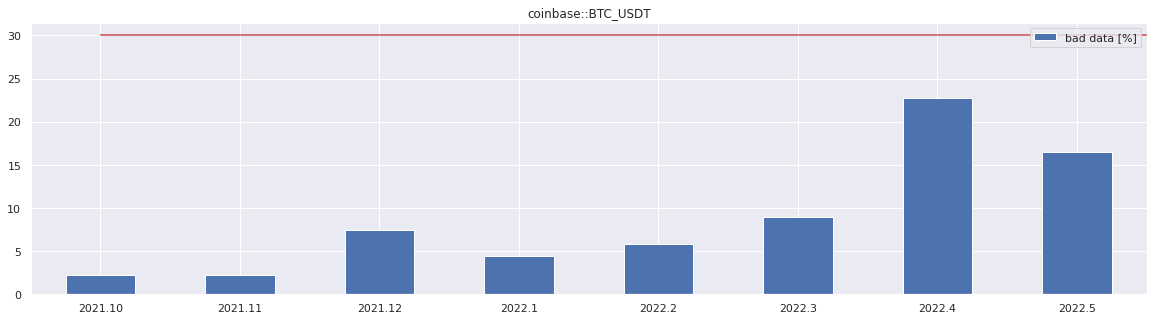

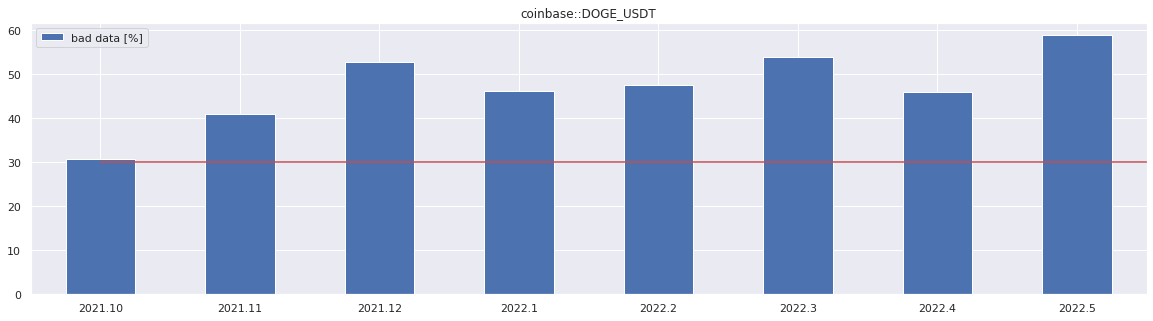

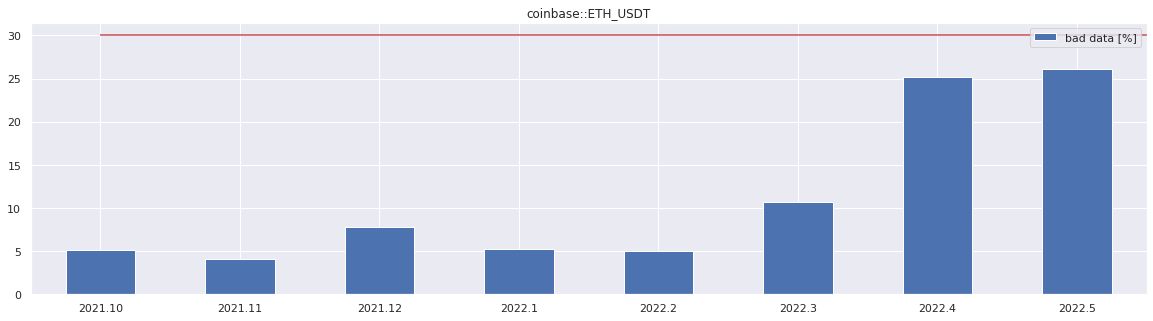

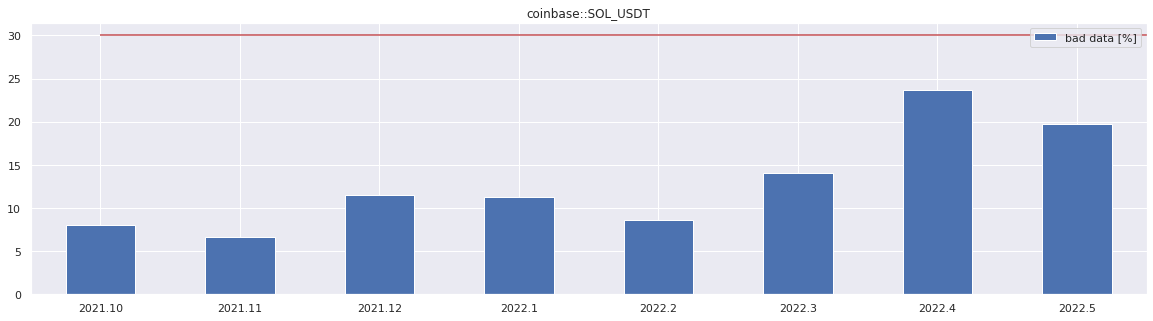

In [13]:
_ = _plot_bad_data_by_year_month_stats(
    config, coinbase_bad_data_stats_by_year_month
)